# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.318196,True,3.222057
1,-0.144570,False,0.721370
2,-2.050888,False,-8.391891
3,-0.812372,True,3.099976
4,-0.672981,False,0.136034
...,...,...,...
995,0.534842,True,8.567794
996,-1.249609,True,0.994439
997,-1.029938,True,2.339349
998,-1.622144,False,-3.628604


<Axes: xlabel='v0'>

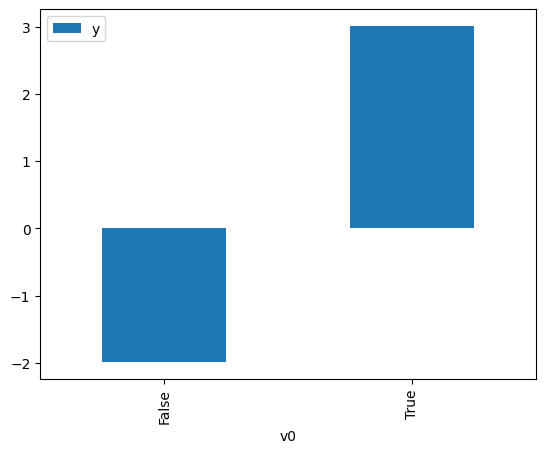

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

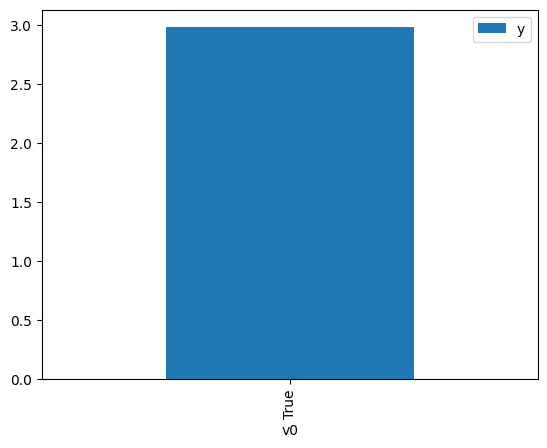

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.407517,False,0.646408,0.563955,1.773192
1,-1.110099,False,-2.577932,0.687450,1.454650
2,-0.752694,False,-3.039133,0.626705,1.595647
3,-1.720676,False,-4.872464,0.777246,1.286594
4,0.360998,False,0.436334,0.419799,2.382095
...,...,...,...,...,...
995,0.054327,False,-0.690331,0.477060,2.096173
996,-0.562014,False,-1.950743,0.592424,1.687981
997,-2.567224,False,-6.684792,0.868698,1.151148
998,-0.410948,False,-3.207409,0.564592,1.771189


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.231003,True,8.846353,0.727333,1.374886
1,-0.449734,True,2.135972,0.428216,2.335272
2,0.590743,True,6.677969,0.621810,1.608209
3,-1.224664,True,1.824150,0.294254,3.398427
4,0.537628,True,5.399970,0.612325,1.633121
...,...,...,...,...,...
995,-2.826951,True,-2.534059,0.110486,9.050956
996,0.599917,True,6.555723,0.623439,1.604006
997,-2.826951,True,-2.534059,0.110486,9.050956
998,-0.558674,True,4.679869,0.408186,2.449864


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.942
Model:                            OLS   Adj. R-squared (uncentered):              0.942
Method:                 Least Squares   F-statistic:                              8163.
Date:                Thu, 12 Feb 2026   Prob (F-statistic):                        0.00
Time:                        23:16:54   Log-Likelihood:                         -1420.8
No. Observations:                1000   AIC:                                      2846.
Df Residuals:                     998   BIC:                                      2855.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.5745      0.026     98.464      0.000       2.523       2.626
x2             5.0620      0.052     97.601      0.000       4.960       5.164
==============================================================================
Omnibus:                        2.374   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.305   Jarque-Bera (JB):                2.229
Skew:                           0.102   Prob(JB):                        0.328
Kurtosis:                       3.110   Cond. No.                         2.04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""